In [1]:

import pandas as pd
import numpy as np
from wft import fetch_yf_data, WalkForward, asses_perf
from wft import Visualization as vis
def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    # Calculate the True Range (TR)
    high_low = high - low
    high_close_prev = (high - close.shift()).abs()
    low_close_prev = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    # Calculate the ATR
    atr = tr.ewm(span=period, min_periods=1, adjust=False).mean() 
    return atr

def compute_indipendet_variables(ohlc: pd.DataFrame, lookahead:int = 1) -> pd.DataFrame:
    # data is already in log form
    open   = ohlc['Open']
    close  = ohlc['Close']
    low    = ohlc['Low']
    high   = ohlc['High']
    volume = ohlc['Volume']

    weekly_atr = compute_atr(high , low , close , 5)
    monthly_atr = compute_atr(high , low , close , 21)

    upper  = high - np.maximum(close , open)
    lower   = np.minimum(close , open)  - low
    assymmetry = upper - lower
    Intraday_assymmetry_standardized = assymmetry/ ( assymmetry.ewm(span = 20, adjust= False).std())

    vol_mean20 = volume.ewm(span = 20, adjust= False).mean()
    vol_surprise = volume  / vol_mean20 -1
    vol_surprise/=vol_surprise.ewm(span = 20, adjust= False).std()

    return5_over_atr = close.diff(5)/monthly_atr 

    df = pd.DataFrame(index = ohlc.index)

    df['return5_over_atr'] = return5_over_atr
    df['Intraday_assymmetry']   = Intraday_assymmetry_standardized
    df['vol_surprise']   = vol_surprise

    target =  close.diff(lookahead).shift(-lookahead)/weekly_atr 
    df.iloc[:20] = np.nan
    target.iloc[:20] = np.nan
    return df, target

The same variables (predictors and target)  explained in the file EXAMPLE_1 are used.

The new model:
- The model used for making predictions will be a Neural Network
- Hyperparametrs => Activation function and number of Hidden neurons, are selcted  using a k-fold Cross Validation,
    => the number of neurons tested will range from 4 to 8, for each we make a test with a 'relu' activation function and a 'sigmoid'
- The variables X and y are standardized at each training step, with the transformation fitted on the training data and then applied at each case of the test set.

Expected Runtime < 10 mins

p-value under H0: mean_return <=0 = 0.08 %
Mean Return: 0.115 %
Lower Confidence Interval: 0.06%
Upper Confidence Interval: 0.18%


c:\Users\andre\Desktop\VS-code_projects\Project\wft\plot_variables.py:237: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = "ffill", inplace =True)


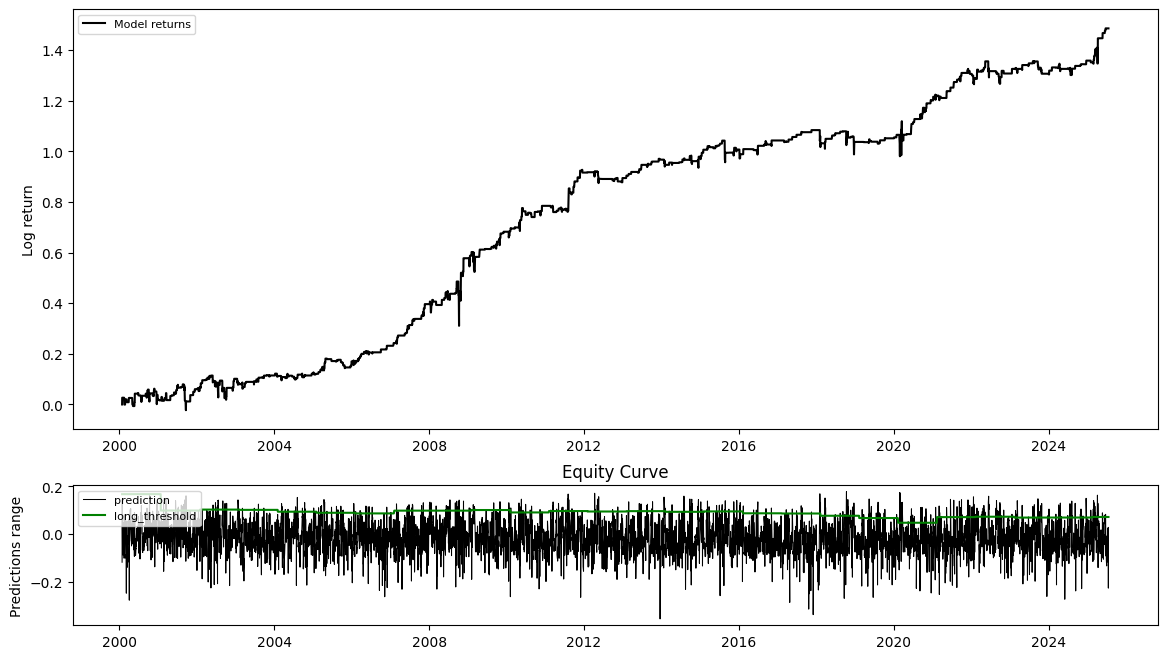

                     mu_long_over_t  std_long  mu_long/std_long
return5_over_atr          -2.006160  0.928144         -2.161474
Intraday_assymmetry        0.464703  0.790940          0.587532
vol_surprise               1.083959  0.631958          1.715239
     Annual Return %  Sharpe Ratio Annualized  Mean Return %  Total Return %  Max Drawdown %  Profit Factor  Sharpe Ratio benchmarck  P-value H0: mean_r <= 0  Time in the market %
SPY             5.23                      1.4           0.12          148.57           17.51           1.42                     0.45                   0.0008                 20.14


In [ ]:

#%%
if __name__ == '__main__':
    data = fetch_yf_data('SPY')
    df,target = compute_indipendet_variables(data)
    ## Inititalize Pipiline Parameters
    inputs = df
    targets = target
    ohlc =data

    max_lookahead = 1
    model_components = ['nn']
    preprocess_variables =  [ 'X','y']
    preprocess_type = ['standardize']
    model_kwargs ={'nn': {'n_hidden':3, 'activation_f':'relu','bias':True,'lr':0.1, 'n_iter':500 }} # Starting Values do not Really matter
    grid_hyperparams = []  ## here we store crossvalidation hyperparameters
    ## Test different number of hidden neurons and activation functions
    for i in range(4,8+1):   ## Max 8 neurons in hidden layer, small models are always better
            grid_hyperparams.append({'nn':{'n_hidden':i, 'activation_f':'relu', 'bias':True}})
            grid_hyperparams.append({'nn':{'n_hidden':i, 'activation_f':'sigmoid', 'bias':True}})
    # Cross Validation Parameters
    # Here we use a 3-fold cross validation, with the evaluation metric being the mean absolute error
    # This means that during each training window, the model will be trained on 3 folds of the data, and the mean absolute error will be used to select the best features.
    kwargs_cv = {'cv_folds': 3, 'eval_metric':'mae'}
    criterion = 'sharpe_ratio'
    min_trades = .1
    min_crit_value = 0
    WF = WalkForward(
                    inputs = inputs,
                    targets = targets,
                    ohlc = ohlc,
                    max_lookahead = max_lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades,
                    model_kwargs = model_kwargs,
                    min_crit_value = min_crit_value,
                    grid_hyperparams=grid_hyperparams,
                    kwargs_cv=kwargs_cv,
                    interaction_terms=False,
                    preprocess_variables = preprocess_variables,
                    preprocess_type = preprocess_type,
                    side = 'long',
                        )

    # Perform WalkForward
    start_train = 252*5  
    train_size =   0 # All past data
    step_size = 252 # Retrain every 12  months because is slow 
    rets, long_stats, short_stats = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commision=0.0001)
    
    mean_ret = np.round(100*rets[rets!=0].mean(),3)
    p_value, ci = asses_perf.p_value_returns(rets.values)
    print(f'p-value under H0: mean_return <=0 = {(100*p_value):.2f} %')
    print(f'Mean Return: {mean_ret} %')
    print(f'Lower Confidence Interval: {(ci[0]):.2f}%')
    print(f'Upper Confidence Interval: {(ci[1]):.2f}%')  
    vis.plot_single_equity_curve(rets,WF.model, WF.inputs,
                                long_stats,short_stats  )
    threshold_dict = {'long': long_stats, 'short': short_stats}
    print(asses_perf.extrapolate_decision_model(WF.inputs,
                                                WF.model, threshold_dict).to_string())
    print(asses_perf.performance_table(rets, 'SPY', data['Close'].diff().fillna(0), 252*5).to_string())


# %%


The neural network based model proposed, shows  net improvements across al metrics, compared to the first linear model, the most important variable seems to be the 5 day standardized return

In [ ]:

for name in long_stats['best_params_cv']:
    print(name['nn']['n_hidden'], name['nn']['activation_f'])

# %%
# The hyperparameters selected at each step of the cross validation are shown below
# They 6 to 8 hidden neurons seem the optimal spot higher number of neurons are not test here, 
# they may very well be better, but the model is already slow to train
# The sigmoid activation function has been always chosen as the best one

6 relu
5 sigmoid
5 sigmoid
5 sigmoid
5 sigmoid
5 sigmoid
5 sigmoid
5 sigmoid
5 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
8 sigmoid
7 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
6 sigmoid
